<a href="https://colab.research.google.com/github/nafiskhan1996/ML/blob/main/Copy_of_CSCE_633_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist
!pip install libauc==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=fb19662dae1e537328aa11ed916af6f9b17f3138bd5ee582fdff2605257b780e
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 9.4 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch import Tensor
from typing import Type

import libauc
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.1 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 205615438/205615438 [10:47<00:00, 317620.60it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


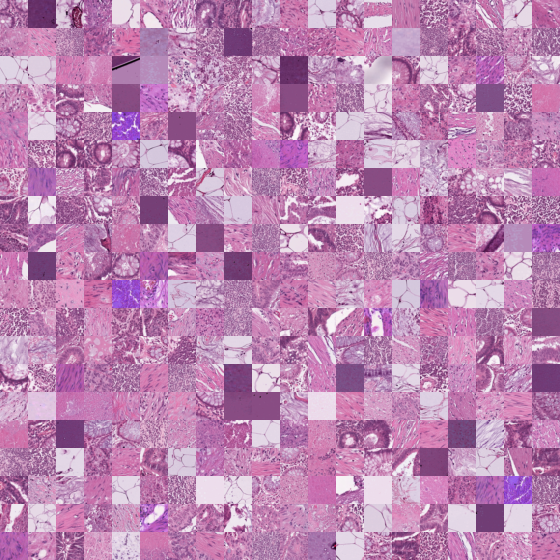

In [ ]:
# visualization
train_dataset.montage(length=1)
# montage
train_dataset.montage(length=20)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
if __name__ == '__main__':
    model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=n_classes)  
    print(model)
    
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

AssertionError: ignored

In [ ]:
# train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/704 [00:00<?, ?it/s]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 1/704 [00:01<15:28,  1.32s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 2/704 [00:02<15:36,  1.33s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 3/704 [00:04<15:53,  1.36s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 4/704 [00:05<14:50,  1.27s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 5/704 [00:06<14:05,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 6/704 [00:07<13:15,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 7/704 [00:08<12:42,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 8/704 [00:09<12:21,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|▏         | 9/704 [00:10<12:02,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|▏         | 10/704 [00:11<11:54,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 11/704 [00:12<11:44,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 12/704 [00:13<11:42,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 13/704 [00:14<12:13,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 14/704 [00:15<13:20,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 15/704 [00:17<13:20,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 16/704 [00:17<12:42,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 17/704 [00:18<12:14,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 18/704 [00:19<11:55,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 19/704 [00:20<11:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 20/704 [00:21<11:41,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 21/704 [00:22<11:38,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 22/704 [00:24<11:42,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 23/704 [00:25<11:39,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 24/704 [00:26<11:33,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▎         | 25/704 [00:27<12:08,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▎         | 26/704 [00:28<13:18,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 27/704 [00:29<13:10,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 28/704 [00:30<12:31,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 29/704 [00:31<12:06,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 30/704 [00:32<11:51,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 31/704 [00:33<11:40,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 32/704 [00:34<11:35,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 33/704 [00:35<11:26,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 34/704 [00:36<11:18,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 35/704 [00:37<11:19,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 36/704 [00:38<11:11,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 37/704 [00:40<11:52,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 38/704 [00:41<12:52,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 39/704 [00:42<12:27,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 40/704 [00:43<12:02,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 41/704 [00:44<11:41,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 42/704 [00:45<11:27,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 43/704 [00:46<11:23,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▋         | 44/704 [00:47<11:34,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▋         | 45/704 [00:48<11:25,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 46/704 [00:49<11:17,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 47/704 [00:50<11:12,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 48/704 [00:51<11:01,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 49/704 [00:52<12:24,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 50/704 [00:54<13:02,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 51/704 [00:55<12:24,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 52/704 [00:56<11:57,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 53/704 [00:57<11:36,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 54/704 [00:58<11:27,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 55/704 [00:59<11:11,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 56/704 [01:00<11:06,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 57/704 [01:01<11:00,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 58/704 [01:02<10:57,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 59/704 [01:03<10:55,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▊         | 60/704 [01:04<11:23,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▊         | 61/704 [01:05<12:29,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 62/704 [01:07<12:33,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 63/704 [01:08<12:00,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 64/704 [01:09<11:33,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 65/704 [01:10<11:16,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 66/704 [01:11<11:02,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 67/704 [01:12<10:53,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 68/704 [01:13<10:44,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 69/704 [01:14<10:45,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 70/704 [01:15<10:43,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 71/704 [01:16<10:42,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 72/704 [01:17<11:23,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 73/704 [01:18<12:22,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 74/704 [01:19<12:14,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 75/704 [01:20<11:43,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 76/704 [01:22<12:21,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 77/704 [01:23<12:32,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 78/704 [01:24<13:00,  1.25s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 79/704 [01:25<12:11,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█▏        | 80/704 [01:26<11:43,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 81/704 [01:27<11:21,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 82/704 [01:28<11:09,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 83/704 [01:30<11:51,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 84/704 [01:31<12:32,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 85/704 [01:32<11:52,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 86/704 [01:33<11:20,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 87/704 [01:34<11:04,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▎        | 88/704 [01:35<11:00,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 89/704 [01:36<10:48,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 90/704 [01:37<10:41,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 91/704 [01:38<10:33,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 92/704 [01:39<10:30,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 93/704 [01:40<10:26,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 94/704 [01:41<10:38,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 95/704 [01:43<11:46,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▎        | 96/704 [01:44<11:55,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 97/704 [01:45<11:21,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 98/704 [01:46<10:59,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 99/704 [01:47<10:42,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 100/704 [01:48<10:34,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 101/704 [01:49<10:21,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 102/704 [01:50<10:23,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 103/704 [01:51<10:17,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 104/704 [01:52<10:19,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 105/704 [01:53<10:12,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 106/704 [01:54<10:55,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 107/704 [01:56<11:52,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 108/704 [01:57<11:45,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 109/704 [01:58<11:15,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 110/704 [01:59<10:50,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 111/704 [02:00<10:36,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 112/704 [02:01<10:25,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 113/704 [02:02<10:16,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 114/704 [02:03<10:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▋        | 115/704 [02:04<10:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▋        | 116/704 [02:05<10:06,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 117/704 [02:06<10:03,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 118/704 [02:08<11:15,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 119/704 [02:09<11:43,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 120/704 [02:10<11:08,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 121/704 [02:11<10:54,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 122/704 [02:12<10:32,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 123/704 [02:13<10:18,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 124/704 [02:14<10:14,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 125/704 [02:15<10:05,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 126/704 [02:16<10:04,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 127/704 [02:17<09:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 128/704 [02:18<10:02,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 129/704 [02:19<10:32,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 130/704 [02:21<11:19,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▊        | 131/704 [02:22<11:23,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 132/704 [02:23<10:51,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 133/704 [02:24<10:29,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 134/704 [02:25<10:25,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 135/704 [02:26<10:12,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 136/704 [02:27<10:07,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 137/704 [02:28<09:56,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 138/704 [02:29<09:47,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 139/704 [02:30<09:38,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 140/704 [02:31<09:40,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 141/704 [02:33<10:43,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 142/704 [02:34<11:08,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 143/704 [02:35<10:39,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 144/704 [02:36<10:17,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 145/704 [02:37<09:57,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 146/704 [02:38<09:46,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 147/704 [02:39<09:37,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 148/704 [02:40<09:30,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 149/704 [02:41<09:30,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██▏       | 150/704 [02:42<09:26,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██▏       | 151/704 [02:43<09:24,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 152/704 [02:44<09:56,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 153/704 [02:46<10:50,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 154/704 [02:47<10:53,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 155/704 [02:48<10:20,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 156/704 [02:49<09:56,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 157/704 [02:50<09:44,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 158/704 [02:51<09:37,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 159/704 [02:52<09:27,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 160/704 [02:53<09:25,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 161/704 [02:54<09:20,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 162/704 [02:55<09:16,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 163/704 [02:56<09:15,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 164/704 [02:57<09:55,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 165/704 [02:59<10:43,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▎       | 166/704 [03:00<10:15,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▎       | 167/704 [03:01<09:52,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 168/704 [03:02<09:35,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 169/704 [03:03<09:19,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 170/704 [03:04<09:14,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 171/704 [03:05<09:09,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 172/704 [03:06<09:06,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 173/704 [03:07<09:04,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 174/704 [03:08<09:02,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 175/704 [03:09<09:03,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 176/704 [03:10<09:58,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 177/704 [03:12<10:22,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 178/704 [03:13<09:54,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 179/704 [03:14<09:37,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 180/704 [03:15<09:20,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 181/704 [03:16<09:12,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 182/704 [03:17<09:03,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 183/704 [03:18<08:57,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 184/704 [03:19<08:54,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▋       | 185/704 [03:20<08:49,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▋       | 186/704 [03:21<08:43,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 187/704 [03:22<09:11,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 188/704 [03:23<10:01,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 189/704 [03:24<10:07,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 190/704 [03:26<09:45,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 191/704 [03:27<09:32,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 192/704 [03:28<09:14,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 193/704 [03:29<09:03,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 194/704 [03:30<08:53,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 195/704 [03:31<08:49,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 196/704 [03:32<08:42,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 197/704 [03:33<08:39,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 198/704 [03:34<08:34,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 199/704 [03:35<09:17,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 200/704 [03:36<10:03,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▊       | 201/704 [03:37<09:38,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▊       | 202/704 [03:38<09:19,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 203/704 [03:39<09:04,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 204/704 [03:40<08:53,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 205/704 [03:41<08:41,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 206/704 [03:42<08:33,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 207/704 [03:43<08:29,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 208/704 [03:45<08:25,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 209/704 [03:46<08:25,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 210/704 [03:47<08:43,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 211/704 [03:48<09:33,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 212/704 [03:49<09:36,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 213/704 [03:50<09:08,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 214/704 [03:51<08:53,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 215/704 [03:52<08:37,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 216/704 [03:53<08:31,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 217/704 [03:54<08:23,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 218/704 [03:55<08:18,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 219/704 [03:56<08:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███▏      | 220/704 [03:57<08:21,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███▏      | 221/704 [03:58<08:17,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 222/704 [04:00<08:51,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 223/704 [04:01<09:27,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 224/704 [04:02<09:16,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 225/704 [04:03<08:55,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 226/704 [04:04<08:39,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 227/704 [04:05<08:25,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 228/704 [04:06<08:15,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 229/704 [04:07<08:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 230/704 [04:08<08:04,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 231/704 [04:09<07:59,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 232/704 [04:10<07:54,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 233/704 [04:11<07:52,  1.00s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 234/704 [04:13<08:45,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 235/704 [04:14<09:15,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▎      | 236/704 [04:15<08:51,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▎      | 237/704 [04:16<08:33,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 238/704 [04:17<08:24,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 239/704 [04:18<08:16,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 240/704 [04:19<08:12,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 241/704 [04:20<08:03,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 242/704 [04:21<07:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 243/704 [04:22<07:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 244/704 [04:23<07:53,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 245/704 [04:24<08:15,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 246/704 [04:26<08:57,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 247/704 [04:27<09:05,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 248/704 [04:28<08:42,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 249/704 [04:29<08:21,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 250/704 [04:30<08:07,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 251/704 [04:31<07:55,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 252/704 [04:32<07:50,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 253/704 [04:33<07:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 254/704 [04:34<07:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 255/704 [04:35<07:40,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▋      | 256/704 [04:36<07:38,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 257/704 [04:38<08:41,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 258/704 [04:39<09:12,  1.24s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 259/704 [04:40<08:40,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 260/704 [04:41<08:18,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 261/704 [04:42<08:00,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 262/704 [04:43<07:51,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 263/704 [04:44<07:43,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 264/704 [04:45<07:36,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 265/704 [04:46<07:32,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 266/704 [04:47<07:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 267/704 [04:48<07:29,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 268/704 [04:49<07:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 269/704 [04:51<08:28,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 270/704 [04:52<08:39,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 271/704 [04:53<08:14,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▊      | 272/704 [04:54<07:58,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 273/704 [04:55<07:46,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 274/704 [04:56<07:35,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 275/704 [04:57<07:33,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 276/704 [04:58<07:29,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 277/704 [04:59<07:23,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 278/704 [05:00<07:21,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 279/704 [05:01<07:16,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 280/704 [05:02<07:42,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 281/704 [05:04<08:15,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 282/704 [05:05<08:12,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 283/704 [05:06<07:51,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 284/704 [05:07<07:41,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 285/704 [05:08<07:29,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 286/704 [05:09<07:20,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 287/704 [05:10<07:14,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 288/704 [05:11<07:11,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 289/704 [05:12<07:06,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 290/704 [05:13<07:01,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████▏     | 291/704 [05:14<06:59,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████▏     | 292/704 [05:15<07:42,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 293/704 [05:17<08:07,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 294/704 [05:18<07:45,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 295/704 [05:19<07:31,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 296/704 [05:20<07:25,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 297/704 [05:21<07:15,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 298/704 [05:22<07:10,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 299/704 [05:23<07:04,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 300/704 [05:24<06:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 301/704 [05:25<06:53,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 302/704 [05:26<06:53,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 303/704 [05:27<07:22,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 304/704 [05:29<08:01,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 305/704 [05:30<07:56,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 306/704 [05:31<07:37,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▎     | 307/704 [05:32<07:23,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 308/704 [05:33<07:12,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 309/704 [05:34<07:04,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 310/704 [05:35<06:57,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 311/704 [05:36<06:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 312/704 [05:37<06:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 313/704 [05:38<06:40,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 314/704 [05:39<06:38,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 315/704 [05:40<07:12,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 316/704 [05:42<07:40,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 317/704 [05:43<07:16,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 318/704 [05:44<07:01,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 319/704 [05:45<06:48,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 320/704 [05:46<06:43,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 321/704 [05:47<06:41,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 322/704 [05:48<06:38,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 323/704 [05:49<06:34,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 324/704 [05:50<06:38,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 325/704 [05:51<06:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▋     | 326/704 [05:52<06:51,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▋     | 327/704 [05:54<07:28,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 328/704 [05:55<07:29,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 329/704 [05:56<07:08,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 330/704 [05:57<06:55,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 331/704 [05:58<06:49,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 332/704 [05:59<06:46,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 333/704 [06:00<06:44,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 334/704 [06:01<06:41,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 335/704 [06:02<06:35,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 336/704 [06:03<06:30,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 337/704 [06:04<06:27,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 338/704 [06:06<07:04,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 339/704 [06:07<07:17,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 340/704 [06:08<06:54,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 341/704 [06:09<06:41,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▊     | 342/704 [06:10<06:31,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▊     | 343/704 [06:11<06:25,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 344/704 [06:12<06:19,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 345/704 [06:13<06:16,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 346/704 [06:14<06:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 347/704 [06:15<06:09,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 348/704 [06:16<06:05,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 349/704 [06:17<06:25,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 350/704 [06:19<06:59,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 351/704 [06:20<06:52,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 352/704 [06:21<06:38,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 353/704 [06:22<06:26,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 354/704 [06:23<06:15,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 355/704 [06:24<06:07,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 356/704 [06:25<06:04,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 357/704 [06:26<06:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 358/704 [06:27<06:04,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 359/704 [06:28<06:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 360/704 [06:29<05:57,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████▏    | 361/704 [06:31<06:40,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████▏    | 362/704 [06:32<06:58,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 363/704 [06:33<06:37,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 364/704 [06:34<06:25,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 365/704 [06:35<06:17,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 366/704 [06:36<06:06,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 367/704 [06:37<05:59,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 368/704 [06:38<05:54,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 369/704 [06:39<05:51,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 370/704 [06:40<05:51,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 371/704 [06:41<05:48,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 372/704 [06:43<06:06,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 373/704 [06:44<06:35,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 374/704 [06:45<06:27,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 375/704 [06:46<06:08,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 376/704 [06:47<05:55,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▎    | 377/704 [06:48<05:49,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▎    | 378/704 [06:49<05:42,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 379/704 [06:50<05:37,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 380/704 [06:51<05:37,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 381/704 [06:52<05:32,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 382/704 [06:53<05:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 383/704 [06:54<05:29,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 384/704 [06:56<05:56,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 385/704 [06:57<06:18,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 386/704 [06:58<06:03,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 387/704 [06:59<05:49,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 388/704 [07:00<05:41,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 389/704 [07:01<05:41,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 390/704 [07:02<05:34,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 391/704 [07:03<05:26,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 392/704 [07:04<05:22,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 393/704 [07:05<05:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 394/704 [07:06<05:18,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 395/704 [07:07<05:35,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▋    | 396/704 [07:09<06:01,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▋    | 397/704 [07:10<05:58,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 398/704 [07:11<05:41,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 399/704 [07:12<05:27,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 400/704 [07:13<05:21,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 401/704 [07:14<05:15,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 402/704 [07:15<05:09,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 403/704 [07:16<05:05,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 404/704 [07:17<05:04,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 405/704 [07:18<05:04,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 406/704 [07:19<05:05,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 407/704 [07:20<05:27,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 408/704 [07:22<05:53,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 409/704 [07:23<05:39,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 410/704 [07:24<05:26,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 411/704 [07:25<05:15,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▊    | 412/704 [07:26<05:09,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▊    | 413/704 [07:27<05:04,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 414/704 [07:28<05:02,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 415/704 [07:29<05:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 416/704 [07:30<04:56,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 417/704 [07:31<04:55,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 418/704 [07:32<05:03,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 419/704 [07:34<05:33,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 420/704 [07:35<05:42,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 421/704 [07:36<05:25,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 422/704 [07:37<05:11,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 423/704 [07:38<05:01,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 424/704 [07:39<04:58,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 425/704 [07:40<04:53,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 426/704 [07:41<04:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 427/704 [07:42<04:44,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 428/704 [07:43<04:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 429/704 [07:44<04:41,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 430/704 [07:45<04:56,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 431/704 [07:47<05:20,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████▏   | 432/704 [07:48<05:18,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 433/704 [07:49<05:04,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 434/704 [07:50<04:54,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 435/704 [07:51<04:46,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 436/704 [07:52<04:42,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 437/704 [07:53<04:37,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 438/704 [07:54<04:34,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 439/704 [07:55<04:31,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▎   | 440/704 [07:56<04:29,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 441/704 [07:57<04:28,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 442/704 [07:58<04:52,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 443/704 [08:00<05:15,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 444/704 [08:01<05:00,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 445/704 [08:02<04:52,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 446/704 [08:03<04:44,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 447/704 [08:04<04:38,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▎   | 448/704 [08:05<04:33,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 449/704 [08:06<04:29,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 450/704 [08:07<04:26,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 451/704 [08:08<04:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 452/704 [08:09<04:19,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 453/704 [08:10<04:32,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 454/704 [08:12<04:58,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 455/704 [08:13<04:59,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 456/704 [08:14<04:45,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 457/704 [08:15<04:35,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 458/704 [08:16<04:26,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 459/704 [08:17<04:20,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 460/704 [08:18<04:15,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 461/704 [08:19<04:11,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 462/704 [08:20<04:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 463/704 [08:21<04:09,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 464/704 [08:22<04:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 465/704 [08:23<04:29,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 466/704 [08:25<04:47,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▋   | 467/704 [08:26<04:33,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▋   | 468/704 [08:27<04:24,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 469/704 [08:28<04:16,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 470/704 [08:29<04:09,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 471/704 [08:30<04:04,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 472/704 [08:31<04:01,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 473/704 [08:32<03:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 474/704 [08:33<04:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 475/704 [08:34<03:55,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 476/704 [08:35<04:04,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 477/704 [08:37<04:25,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 478/704 [08:38<04:26,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 479/704 [08:39<04:14,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 480/704 [08:40<04:06,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 481/704 [08:41<04:02,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 482/704 [08:42<03:55,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▊   | 483/704 [08:43<03:50,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 484/704 [08:44<03:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 485/704 [08:45<03:46,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 486/704 [08:46<03:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 487/704 [08:47<03:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 488/704 [08:48<03:58,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 489/704 [08:50<04:17,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 490/704 [08:51<04:09,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 491/704 [08:52<04:00,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 492/704 [08:53<03:52,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 493/704 [08:54<03:48,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 494/704 [08:55<03:44,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 495/704 [08:56<03:40,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 496/704 [08:57<03:35,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 497/704 [08:58<03:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 498/704 [08:59<03:32,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 499/704 [09:00<03:37,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 500/704 [09:02<04:00,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 501/704 [09:03<04:06,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████▏  | 502/704 [09:04<03:54,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████▏  | 503/704 [09:05<03:43,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 504/704 [09:06<03:38,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 505/704 [09:07<03:33,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 506/704 [09:08<03:28,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 507/704 [09:09<03:23,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 508/704 [09:10<03:21,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 509/704 [09:11<03:18,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 510/704 [09:12<03:17,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 511/704 [09:13<03:29,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 512/704 [09:15<03:50,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 513/704 [09:16<03:43,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 514/704 [09:17<03:33,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 515/704 [09:18<03:26,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 516/704 [09:19<03:20,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 517/704 [09:20<03:17,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▎  | 518/704 [09:21<03:13,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▎  | 519/704 [09:22<03:11,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 520/704 [09:23<03:11,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 521/704 [09:24<03:08,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 522/704 [09:25<03:06,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 523/704 [09:26<03:25,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 524/704 [09:28<03:33,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 525/704 [09:29<03:24,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 526/704 [09:30<03:17,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 527/704 [09:31<03:11,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 528/704 [09:32<03:05,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 529/704 [09:33<03:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 530/704 [09:34<03:02,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 531/704 [09:35<02:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 532/704 [09:36<02:57,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 533/704 [09:37<02:56,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 534/704 [09:38<03:06,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 535/704 [09:40<03:21,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 536/704 [09:41<03:20,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▋  | 537/704 [09:42<03:11,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▋  | 538/704 [09:43<03:04,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 539/704 [09:44<02:58,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 540/704 [09:45<02:54,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 541/704 [09:46<02:49,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 542/704 [09:47<02:45,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 543/704 [09:48<02:42,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 544/704 [09:49<02:41,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 545/704 [09:50<02:40,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 546/704 [09:51<02:53,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 547/704 [09:52<03:06,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 548/704 [09:54<02:58,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 549/704 [09:55<02:50,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 550/704 [09:56<02:44,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 551/704 [09:57<02:40,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 552/704 [09:58<02:37,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▊  | 553/704 [09:59<02:36,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▊  | 554/704 [10:00<02:34,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 555/704 [10:01<02:33,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 556/704 [10:02<02:32,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 557/704 [10:03<02:35,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 558/704 [10:04<02:53,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 559/704 [10:05<02:54,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 560/704 [10:07<02:46,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 561/704 [10:08<02:39,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 562/704 [10:09<02:35,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 563/704 [10:10<02:30,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 564/704 [10:11<02:27,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 565/704 [10:12<02:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 566/704 [10:13<02:24,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 567/704 [10:14<02:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 568/704 [10:15<02:20,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 569/704 [10:16<02:31,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 570/704 [10:17<02:41,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 571/704 [10:19<02:33,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████▏ | 572/704 [10:20<02:27,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████▏ | 573/704 [10:21<02:23,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 574/704 [10:22<02:19,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 575/704 [10:23<02:15,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 576/704 [10:24<02:13,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 577/704 [10:25<02:11,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 578/704 [10:26<02:10,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 579/704 [10:27<02:08,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 580/704 [10:28<02:11,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 581/704 [10:29<02:23,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 582/704 [10:31<02:25,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 583/704 [10:32<02:18,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 584/704 [10:33<02:12,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 585/704 [10:34<02:09,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 586/704 [10:35<02:06,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 587/704 [10:36<02:03,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▎ | 588/704 [10:37<02:02,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▎ | 589/704 [10:38<01:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 590/704 [10:39<01:57,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 591/704 [10:40<01:56,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 592/704 [10:41<02:02,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 593/704 [10:42<02:11,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 594/704 [10:43<02:07,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 595/704 [10:44<02:01,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 596/704 [10:46<01:57,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 597/704 [10:47<01:54,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 598/704 [10:48<01:51,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 599/704 [10:49<01:49,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 600/704 [10:50<01:47,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 601/704 [10:51<01:46,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 602/704 [10:52<01:45,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 603/704 [10:53<01:42,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 604/704 [10:54<01:53,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 605/704 [10:55<01:57,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 606/704 [10:56<01:50,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 607/704 [10:57<01:46,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▋ | 608/704 [10:58<01:44,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 609/704 [10:59<01:41,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 610/704 [11:00<01:39,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 611/704 [11:02<01:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 612/704 [11:03<01:35,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 613/704 [11:04<01:33,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 614/704 [11:05<01:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 615/704 [11:06<01:37,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 616/704 [11:07<01:45,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 617/704 [11:09<01:45,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 618/704 [11:10<01:39,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 619/704 [11:11<01:34,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 620/704 [11:12<01:31,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 621/704 [11:13<01:29,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 622/704 [11:14<01:26,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 623/704 [11:15<01:23,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▊ | 624/704 [11:16<01:21,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 625/704 [11:17<01:20,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 626/704 [11:18<01:19,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 627/704 [11:19<01:25,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 628/704 [11:20<01:29,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 629/704 [11:21<01:25,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 630/704 [11:22<01:20,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 631/704 [11:23<01:17,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 632/704 [11:24<01:16,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 633/704 [11:25<01:14,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 634/704 [11:26<01:13,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 635/704 [11:27<01:11,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 636/704 [11:28<01:09,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 637/704 [11:29<01:08,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 638/704 [11:31<01:09,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 639/704 [11:32<01:15,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 640/704 [11:33<01:15,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 641/704 [11:34<01:11,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 642/704 [11:35<01:07,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████▏| 643/704 [11:36<01:05,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████▏| 644/704 [11:37<01:04,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 645/704 [11:38<01:02,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 646/704 [11:39<01:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 647/704 [11:40<00:58,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 648/704 [11:41<00:57,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 649/704 [11:42<00:55,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 650/704 [11:44<00:58,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 651/704 [11:45<01:02,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 652/704 [11:46<00:59,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 653/704 [11:47<00:56,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 654/704 [11:48<00:53,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 655/704 [11:49<00:51,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 656/704 [11:50<00:50,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 657/704 [11:51<00:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 658/704 [11:52<00:47,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▎| 659/704 [11:53<00:46,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 660/704 [11:54<00:45,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 661/704 [11:55<00:44,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 662/704 [11:57<00:48,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 663/704 [11:58<00:48,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 664/704 [11:59<00:45,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 665/704 [12:00<00:42,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 666/704 [12:01<00:41,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 667/704 [12:02<00:39,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 668/704 [12:03<00:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 669/704 [12:04<00:36,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 670/704 [12:05<00:35,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 671/704 [12:06<00:34,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 672/704 [12:07<00:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 673/704 [12:09<00:34,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 674/704 [12:10<00:36,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 675/704 [12:11<00:34,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 676/704 [12:12<00:31,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 677/704 [12:13<00:29,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▋| 678/704 [12:14<00:27,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▋| 679/704 [12:15<00:26,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 680/704 [12:16<00:24,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 681/704 [12:17<00:23,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 682/704 [12:18<00:22,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 683/704 [12:19<00:21,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 684/704 [12:20<00:20,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 685/704 [12:22<00:21,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 686/704 [12:23<00:21,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 687/704 [12:24<00:19,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 688/704 [12:25<00:17,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 689/704 [12:26<00:16,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 690/704 [12:27<00:14,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 691/704 [12:28<00:13,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 692/704 [12:29<00:12,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 693/704 [12:30<00:11,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▊| 694/704 [12:31<00:10,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▊| 695/704 [12:32<00:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 696/704 [12:33<00:08,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 697/704 [12:35<00:08,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 698/704 [12:36<00:07,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 699/704 [12:37<00:05,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 700/704 [12:38<00:04,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|█████████▉| 701/704 [12:39<00:03,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|█████████▉| 702/704 [12:40<00:02,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|██████████| 704/704 [12:41<00:00,  1.08s/it]


Dimensions of the last convolutional feature map:  torch.Size([12, 512, 1, 1])


  0%|          | 0/704 [00:00<?, ?it/s]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 1/704 [00:01<12:16,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 2/704 [00:02<12:08,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 3/704 [00:03<12:07,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 4/704 [00:04<12:42,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 5/704 [00:05<13:59,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 6/704 [00:06<13:57,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 7/704 [00:07<13:13,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 8/704 [00:08<12:46,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|▏         | 9/704 [00:09<12:36,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|▏         | 10/704 [00:10<12:21,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 11/704 [00:12<12:09,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 12/704 [00:13<12:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 13/704 [00:14<12:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 14/704 [00:15<11:52,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 15/704 [00:16<11:50,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 16/704 [00:17<12:52,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 17/704 [00:18<13:48,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 18/704 [00:19<13:09,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 19/704 [00:20<12:37,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 20/704 [00:21<12:20,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 21/704 [00:22<12:12,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 22/704 [00:24<12:09,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 23/704 [00:25<12:07,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 24/704 [00:26<11:59,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▎         | 25/704 [00:27<11:59,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▎         | 26/704 [00:28<11:49,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 27/704 [00:29<12:24,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 28/704 [00:30<13:21,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 29/704 [00:31<13:19,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 30/704 [00:33<12:44,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 31/704 [00:34<12:18,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 32/704 [00:35<12:00,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 33/704 [00:36<11:47,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 34/704 [00:37<11:41,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 35/704 [00:38<11:32,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 36/704 [00:39<11:27,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 37/704 [00:40<11:27,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 38/704 [00:41<11:25,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 39/704 [00:42<12:24,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 40/704 [00:43<13:15,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 41/704 [00:44<12:42,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 42/704 [00:45<12:17,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 43/704 [00:46<12:04,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▋         | 44/704 [00:48<11:53,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▋         | 45/704 [00:49<11:38,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 46/704 [00:50<11:32,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 47/704 [00:51<11:30,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 48/704 [00:52<11:20,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 49/704 [00:53<11:13,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 50/704 [00:54<12:02,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 51/704 [00:55<13:08,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 52/704 [00:57<13:00,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 53/704 [00:58<12:21,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 54/704 [00:59<12:03,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 55/704 [01:00<11:41,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 56/704 [01:01<11:25,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 57/704 [01:02<11:15,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 58/704 [01:03<11:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 59/704 [01:04<11:05,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▊         | 60/704 [01:05<10:58,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▊         | 61/704 [01:06<11:05,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 62/704 [01:07<12:04,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 63/704 [01:08<12:58,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 64/704 [01:10<12:22,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 65/704 [01:11<11:54,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 66/704 [01:12<11:30,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 67/704 [01:13<11:23,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 68/704 [01:14<11:15,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 69/704 [01:15<11:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 70/704 [01:16<11:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 71/704 [01:17<10:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 72/704 [01:18<10:53,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 73/704 [01:19<11:24,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 74/704 [01:20<12:22,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 75/704 [01:22<12:24,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 76/704 [01:23<11:52,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 77/704 [01:24<11:35,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 78/704 [01:25<11:38,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 79/704 [01:26<11:21,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█▏        | 80/704 [01:27<11:06,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 81/704 [01:28<10:54,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 82/704 [01:29<10:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 83/704 [01:30<10:50,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 84/704 [01:31<10:53,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 85/704 [01:32<12:01,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 86/704 [01:34<12:20,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 87/704 [01:35<11:40,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▎        | 88/704 [01:36<11:19,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 89/704 [01:37<11:03,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 90/704 [01:38<10:46,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 91/704 [01:39<10:41,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 92/704 [01:40<10:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 93/704 [01:41<10:26,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 94/704 [01:42<10:21,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 95/704 [01:43<10:17,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▎        | 96/704 [01:44<10:51,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 97/704 [01:45<12:05,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 98/704 [01:47<12:10,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 99/704 [01:48<11:29,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 100/704 [01:49<11:04,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 101/704 [01:50<10:46,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 102/704 [01:51<10:36,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 103/704 [01:52<10:32,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 104/704 [01:53<10:18,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 105/704 [01:54<10:13,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 106/704 [01:55<10:19,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 107/704 [01:56<10:18,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 108/704 [01:57<11:08,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 109/704 [01:59<12:08,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 110/704 [02:00<11:36,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 111/704 [02:01<11:09,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 112/704 [02:02<10:49,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 113/704 [02:03<10:34,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 114/704 [02:04<10:20,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▋        | 115/704 [02:05<10:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▋        | 116/704 [02:06<10:01,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 117/704 [02:07<09:56,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 118/704 [02:08<09:56,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 119/704 [02:09<09:53,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 120/704 [02:10<11:05,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 121/704 [02:11<11:25,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 122/704 [02:12<11:04,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 123/704 [02:14<10:43,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 124/704 [02:15<10:25,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 125/704 [02:16<10:13,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 126/704 [02:17<10:10,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 127/704 [02:18<10:01,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 128/704 [02:19<09:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 129/704 [02:20<09:55,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 130/704 [02:21<09:45,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▊        | 131/704 [02:22<10:19,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 132/704 [02:23<11:22,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 133/704 [02:25<11:28,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 134/704 [02:26<11:10,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 135/704 [02:27<10:45,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 136/704 [02:28<10:24,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 137/704 [02:29<10:13,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 138/704 [02:30<10:01,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 139/704 [02:31<09:49,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 140/704 [02:32<09:47,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 141/704 [02:33<09:42,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 142/704 [02:34<09:40,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 143/704 [02:35<10:37,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 144/704 [02:36<10:59,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 145/704 [02:38<10:32,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 146/704 [02:39<10:09,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 147/704 [02:40<09:59,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 148/704 [02:41<09:45,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 149/704 [02:42<09:39,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██▏       | 150/704 [02:43<09:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██▏       | 151/704 [02:44<09:30,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 152/704 [02:45<09:27,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 153/704 [02:46<09:21,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 154/704 [02:47<09:53,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 155/704 [02:48<10:51,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 156/704 [02:50<10:53,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 157/704 [02:51<10:22,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 158/704 [02:52<10:02,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 159/704 [02:53<09:46,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 160/704 [02:54<09:31,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 161/704 [02:55<09:21,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 162/704 [02:56<09:13,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 163/704 [02:57<09:08,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 164/704 [02:58<09:06,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 165/704 [02:59<09:15,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▎       | 166/704 [03:00<10:04,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▎       | 167/704 [03:01<10:43,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 168/704 [03:02<10:18,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 169/704 [03:03<09:56,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 170/704 [03:04<09:43,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 171/704 [03:05<09:29,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 172/704 [03:06<09:22,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 173/704 [03:07<09:15,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 174/704 [03:09<09:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 175/704 [03:10<09:08,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 176/704 [03:11<09:02,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 177/704 [03:12<09:17,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 178/704 [03:13<10:12,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 179/704 [03:14<10:20,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 180/704 [03:15<09:50,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 181/704 [03:16<09:42,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 182/704 [03:17<09:31,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 183/704 [03:18<09:15,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 184/704 [03:19<09:06,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▋       | 185/704 [03:20<08:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▋       | 186/704 [03:22<08:56,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 187/704 [03:23<08:54,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 188/704 [03:24<08:47,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 189/704 [03:25<09:23,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 190/704 [03:26<10:09,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 191/704 [03:27<10:02,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 192/704 [03:28<09:49,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 193/704 [03:30<09:38,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 194/704 [03:31<09:25,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 195/704 [03:32<09:14,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 196/704 [03:33<09:13,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 197/704 [03:34<08:58,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 198/704 [03:35<08:51,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 199/704 [03:36<08:46,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 200/704 [03:37<09:05,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▊       | 201/704 [03:38<09:56,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▊       | 202/704 [03:40<10:05,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 203/704 [03:41<09:36,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 204/704 [03:42<09:22,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 205/704 [03:43<09:06,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 206/704 [03:44<08:55,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 207/704 [03:45<08:45,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 208/704 [03:46<08:40,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 209/704 [03:47<08:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 210/704 [03:48<08:32,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 211/704 [03:49<08:29,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 212/704 [03:50<09:13,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 213/704 [03:52<09:53,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 214/704 [03:53<09:33,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 215/704 [03:54<09:16,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 216/704 [03:55<09:00,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 217/704 [03:56<08:50,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 218/704 [03:57<08:41,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 219/704 [03:58<08:33,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███▏      | 220/704 [03:59<08:34,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███▏      | 221/704 [04:00<08:28,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 222/704 [04:01<08:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 223/704 [04:02<08:48,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 224/704 [04:04<09:28,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 225/704 [04:05<09:23,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 226/704 [04:06<09:02,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 227/704 [04:07<08:43,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 228/704 [04:08<08:31,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 229/704 [04:09<08:23,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 230/704 [04:10<08:21,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 231/704 [04:11<08:15,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 232/704 [04:12<08:08,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 233/704 [04:13<08:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 234/704 [04:14<08:06,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 235/704 [04:15<08:51,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▎      | 236/704 [04:17<09:15,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▎      | 237/704 [04:18<08:53,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 238/704 [04:19<08:38,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 239/704 [04:20<08:21,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 240/704 [04:21<08:11,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 241/704 [04:22<08:07,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 242/704 [04:23<08:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 243/704 [04:24<07:54,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 244/704 [04:25<07:51,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 245/704 [04:26<07:45,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 246/704 [04:27<08:14,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 247/704 [04:29<09:04,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 248/704 [04:30<09:07,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 249/704 [04:31<08:42,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 250/704 [04:32<08:23,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 251/704 [04:33<08:11,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 252/704 [04:34<08:06,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 253/704 [04:35<07:58,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 254/704 [04:36<07:54,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 255/704 [04:37<07:46,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▋      | 256/704 [04:38<07:41,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 257/704 [04:39<07:41,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 258/704 [04:40<08:30,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 259/704 [04:42<08:58,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 260/704 [04:43<08:30,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 261/704 [04:44<08:14,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 262/704 [04:45<08:02,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 263/704 [04:46<07:54,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 264/704 [04:47<07:49,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 265/704 [04:48<07:49,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 266/704 [04:49<07:44,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 267/704 [04:50<07:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 268/704 [04:51<07:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 269/704 [04:52<07:58,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 270/704 [04:54<08:33,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 271/704 [04:55<08:33,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▊      | 272/704 [04:56<08:10,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 273/704 [04:57<07:52,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 274/704 [04:58<07:38,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 275/704 [04:59<07:30,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 276/704 [05:00<07:33,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 277/704 [05:01<07:31,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 278/704 [05:02<07:25,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 279/704 [05:03<07:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 280/704 [05:04<07:17,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 281/704 [05:06<08:01,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 282/704 [05:07<08:27,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 283/704 [05:08<08:01,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 284/704 [05:09<07:42,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 285/704 [05:10<07:31,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 286/704 [05:11<07:21,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 287/704 [05:12<07:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 288/704 [05:13<07:08,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 289/704 [05:14<07:03,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 290/704 [05:15<07:01,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████▏     | 291/704 [05:16<06:59,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████▏     | 292/704 [05:17<07:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 293/704 [05:18<07:47,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 294/704 [05:20<08:02,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 295/704 [05:21<07:40,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 296/704 [05:22<07:28,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 297/704 [05:23<07:15,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 298/704 [05:24<07:05,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 299/704 [05:25<06:58,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 300/704 [05:26<06:54,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 301/704 [05:27<06:50,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 302/704 [05:28<06:47,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 303/704 [05:29<06:47,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 304/704 [05:30<07:17,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 305/704 [05:31<07:57,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 306/704 [05:33<07:48,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▎     | 307/704 [05:34<07:26,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 308/704 [05:35<07:12,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 309/704 [05:36<07:04,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 310/704 [05:37<06:54,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 311/704 [05:38<06:46,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 312/704 [05:39<06:44,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 313/704 [05:40<06:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 314/704 [05:41<06:42,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 315/704 [05:42<06:35,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 316/704 [05:43<07:07,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 317/704 [05:44<07:34,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 318/704 [05:45<07:12,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 319/704 [05:46<06:57,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 320/704 [05:47<06:46,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 321/704 [05:48<06:39,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 322/704 [05:49<06:36,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 323/704 [05:50<06:33,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 324/704 [05:51<06:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 325/704 [05:53<06:32,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▋     | 326/704 [05:54<06:29,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▋     | 327/704 [05:55<06:36,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 328/704 [05:56<07:13,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 329/704 [05:57<07:21,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 330/704 [05:58<07:00,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 331/704 [05:59<06:44,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 332/704 [06:00<06:40,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 333/704 [06:01<06:33,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 334/704 [06:02<06:25,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 335/704 [06:03<06:20,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 336/704 [06:04<06:15,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 337/704 [06:05<06:14,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 338/704 [06:06<06:11,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 339/704 [06:08<06:35,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 340/704 [06:09<07:09,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 341/704 [06:10<07:07,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▊     | 342/704 [06:11<06:45,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▊     | 343/704 [06:12<06:32,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 344/704 [06:13<06:23,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 345/704 [06:14<06:14,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 346/704 [06:15<06:09,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 347/704 [06:16<06:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 348/704 [06:17<06:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 349/704 [06:18<06:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 350/704 [06:19<06:06,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 351/704 [06:21<06:41,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 352/704 [06:22<06:59,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 353/704 [06:23<06:41,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 354/704 [06:24<06:24,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 355/704 [06:25<06:16,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 356/704 [06:26<06:08,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 357/704 [06:27<06:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 358/704 [06:28<06:01,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 359/704 [06:29<06:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 360/704 [06:30<06:01,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████▏    | 361/704 [06:31<06:04,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████▏    | 362/704 [06:33<06:27,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 363/704 [06:34<06:54,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 364/704 [06:35<06:43,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 365/704 [06:36<06:24,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 366/704 [06:37<06:10,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 367/704 [06:38<06:03,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 368/704 [06:39<05:58,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 369/704 [06:40<05:55,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 370/704 [06:41<05:50,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 371/704 [06:42<05:45,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 372/704 [06:43<05:45,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 373/704 [06:45<05:52,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 374/704 [06:46<06:33,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 375/704 [06:47<06:36,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 376/704 [06:48<06:14,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▎    | 377/704 [06:49<06:04,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▎    | 378/704 [06:50<05:54,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 379/704 [06:51<05:49,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 380/704 [06:52<05:43,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 381/704 [06:53<05:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 382/704 [06:54<05:30,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 383/704 [06:55<05:26,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 384/704 [06:56<05:28,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 385/704 [06:58<05:48,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 386/704 [06:59<06:18,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 387/704 [07:00<06:15,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 388/704 [07:01<06:06,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 389/704 [07:02<05:53,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 390/704 [07:03<05:40,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 391/704 [07:04<05:35,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 392/704 [07:05<05:29,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 393/704 [07:06<05:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 394/704 [07:07<05:19,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 395/704 [07:08<05:16,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▋    | 396/704 [07:10<05:14,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▋    | 397/704 [07:11<05:48,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 398/704 [07:12<06:00,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 399/704 [07:13<05:44,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 400/704 [07:14<05:30,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 401/704 [07:15<05:21,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 402/704 [07:16<05:16,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 403/704 [07:17<05:11,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 404/704 [07:18<05:08,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 405/704 [07:19<05:04,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 406/704 [07:20<05:03,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 407/704 [07:21<05:02,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 408/704 [07:22<05:18,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 409/704 [07:24<05:49,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 410/704 [07:25<05:55,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 411/704 [07:26<05:38,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▊    | 412/704 [07:27<05:27,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▊    | 413/704 [07:28<05:16,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 414/704 [07:29<05:10,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 415/704 [07:30<05:06,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 416/704 [07:31<05:08,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 417/704 [07:32<05:07,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 418/704 [07:33<05:01,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 419/704 [07:35<04:56,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 420/704 [07:36<05:18,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 421/704 [07:37<05:38,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 422/704 [07:38<05:20,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 423/704 [07:39<05:08,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 424/704 [07:40<05:02,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 425/704 [07:41<04:56,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 426/704 [07:42<04:52,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 427/704 [07:43<04:46,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 428/704 [07:44<04:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 429/704 [07:45<04:41,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 430/704 [07:46<04:43,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 431/704 [07:47<04:50,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████▏   | 432/704 [07:49<05:20,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 433/704 [07:50<05:21,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 434/704 [07:51<05:06,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 435/704 [07:52<04:57,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 436/704 [07:53<04:49,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 437/704 [07:54<04:44,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 438/704 [07:55<04:39,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 439/704 [07:56<04:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▎   | 440/704 [07:57<04:31,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 441/704 [07:58<04:29,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 442/704 [07:59<04:28,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 443/704 [08:01<04:44,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 444/704 [08:02<05:14,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 445/704 [08:03<05:09,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 446/704 [08:04<04:53,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 447/704 [08:05<04:42,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▎   | 448/704 [08:06<04:31,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 449/704 [08:07<04:24,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 450/704 [08:08<04:22,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 451/704 [08:09<04:19,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 452/704 [08:10<04:17,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 453/704 [08:11<04:14,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 454/704 [08:12<04:14,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 455/704 [08:14<04:37,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 456/704 [08:15<04:57,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 457/704 [08:16<04:46,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 458/704 [08:17<04:33,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 459/704 [08:18<04:25,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 460/704 [08:19<04:19,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 461/704 [08:20<04:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 462/704 [08:21<04:08,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 463/704 [08:22<04:09,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 464/704 [08:23<04:07,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 465/704 [08:24<04:04,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 466/704 [08:25<04:14,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▋   | 467/704 [08:27<04:36,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▋   | 468/704 [08:28<04:40,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 469/704 [08:29<04:29,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 470/704 [08:30<04:22,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 471/704 [08:31<04:13,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 472/704 [08:32<04:11,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 473/704 [08:33<04:10,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 474/704 [08:34<04:04,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 475/704 [08:35<04:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 476/704 [08:36<03:57,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 477/704 [08:37<03:52,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 478/704 [08:39<04:07,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 479/704 [08:40<04:29,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 480/704 [08:41<04:17,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 481/704 [08:42<04:09,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 482/704 [08:43<04:02,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▊   | 483/704 [08:44<03:57,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 484/704 [08:45<03:53,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 485/704 [08:46<03:53,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 486/704 [08:47<03:51,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 487/704 [08:48<03:46,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 488/704 [08:49<03:46,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 489/704 [08:51<03:57,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 490/704 [08:52<04:18,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 491/704 [08:53<04:23,  1.24s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 492/704 [08:54<04:09,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 493/704 [08:55<03:58,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 494/704 [08:56<03:49,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 495/704 [08:57<03:43,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 496/704 [08:58<03:38,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 497/704 [08:59<03:35,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 498/704 [09:00<03:30,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 499/704 [09:01<03:28,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 500/704 [09:02<03:31,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 501/704 [09:04<03:51,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████▏  | 502/704 [09:05<04:04,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████▏  | 503/704 [09:06<03:52,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 504/704 [09:07<03:43,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 505/704 [09:08<03:37,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 506/704 [09:09<03:32,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 507/704 [09:10<03:26,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 508/704 [09:11<03:24,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 509/704 [09:12<03:23,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 510/704 [09:13<03:21,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 511/704 [09:14<03:18,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 512/704 [09:16<03:26,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 513/704 [09:17<03:46,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 514/704 [09:18<03:45,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 515/704 [09:19<03:35,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 516/704 [09:20<03:25,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 517/704 [09:21<03:20,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▎  | 518/704 [09:22<03:17,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▎  | 519/704 [09:23<03:13,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 520/704 [09:24<03:11,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 521/704 [09:25<03:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 522/704 [09:26<03:07,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 523/704 [09:28<03:07,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 524/704 [09:29<03:22,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 525/704 [09:30<03:38,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 526/704 [09:31<03:26,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 527/704 [09:32<03:19,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 528/704 [09:33<03:13,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 529/704 [09:34<03:09,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 530/704 [09:35<03:05,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 531/704 [09:36<03:02,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 532/704 [09:38<03:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 533/704 [09:39<02:58,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 534/704 [09:40<02:56,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 535/704 [09:41<03:02,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 536/704 [09:42<03:19,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▋  | 537/704 [09:43<03:20,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▋  | 538/704 [09:44<03:11,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 539/704 [09:46<03:03,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 540/704 [09:47<03:00,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 541/704 [09:48<02:56,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 542/704 [09:49<02:52,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 543/704 [09:50<02:49,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 544/704 [09:51<02:46,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 545/704 [09:52<02:44,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 546/704 [09:53<02:42,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 547/704 [09:54<02:57,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 548/704 [09:55<03:07,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 549/704 [09:56<02:57,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 550/704 [09:57<02:51,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 551/704 [09:59<02:47,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 552/704 [10:00<02:43,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▊  | 553/704 [10:01<02:43,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▊  | 554/704 [10:02<02:40,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 555/704 [10:03<02:37,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 556/704 [10:04<02:37,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 557/704 [10:05<02:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 558/704 [10:06<02:40,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 559/704 [10:07<02:53,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 560/704 [10:09<02:51,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 561/704 [10:10<02:44,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 562/704 [10:11<02:37,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 563/704 [10:12<02:31,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 564/704 [10:13<02:27,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 565/704 [10:14<02:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 566/704 [10:15<02:23,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 567/704 [10:16<02:21,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 568/704 [10:17<02:19,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 569/704 [10:18<02:18,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 570/704 [10:19<02:28,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 571/704 [10:21<02:39,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████▏ | 572/704 [10:22<02:29,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████▏ | 573/704 [10:23<02:24,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 574/704 [10:24<02:21,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 575/704 [10:25<02:17,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 576/704 [10:26<02:16,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 577/704 [10:27<02:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 578/704 [10:28<02:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 579/704 [10:29<02:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 580/704 [10:30<02:08,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 581/704 [10:31<02:15,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 582/704 [10:32<02:25,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 583/704 [10:34<02:26,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 584/704 [10:35<02:17,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 585/704 [10:36<02:10,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 586/704 [10:37<02:06,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 587/704 [10:38<02:03,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▎ | 588/704 [10:39<02:01,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▎ | 589/704 [10:40<01:58,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 590/704 [10:41<01:56,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 591/704 [10:42<01:54,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 592/704 [10:43<01:53,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 593/704 [10:44<02:00,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 594/704 [10:45<02:09,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 595/704 [10:46<02:05,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 596/704 [10:47<01:59,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 597/704 [10:48<01:55,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 598/704 [10:49<01:52,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 599/704 [10:51<01:50,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 600/704 [10:52<01:48,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 601/704 [10:53<01:45,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 602/704 [10:54<01:44,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 603/704 [10:55<01:42,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 604/704 [10:56<01:44,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 605/704 [10:57<01:53,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 606/704 [10:58<01:54,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 607/704 [10:59<01:48,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▋ | 608/704 [11:00<01:43,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 609/704 [11:01<01:41,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 610/704 [11:02<01:38,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 611/704 [11:03<01:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 612/704 [11:04<01:38,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 613/704 [11:06<01:36,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 614/704 [11:07<01:34,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 615/704 [11:08<01:31,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 616/704 [11:09<01:36,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 617/704 [11:10<01:42,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 618/704 [11:11<01:39,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 619/704 [11:12<01:34,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 620/704 [11:13<01:30,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 621/704 [11:14<01:28,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 622/704 [11:15<01:26,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 623/704 [11:16<01:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▊ | 624/704 [11:17<01:23,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 625/704 [11:18<01:22,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 626/704 [11:19<01:20,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 627/704 [11:20<01:18,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 628/704 [11:22<01:25,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 629/704 [11:23<01:28,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 630/704 [11:24<01:23,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 631/704 [11:25<01:19,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 632/704 [11:26<01:17,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 633/704 [11:27<01:15,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 634/704 [11:28<01:13,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 635/704 [11:29<01:12,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 636/704 [11:30<01:11,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 637/704 [11:31<01:10,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 638/704 [11:32<01:09,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 639/704 [11:34<01:12,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 640/704 [11:35<01:18,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 641/704 [11:36<01:16,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 642/704 [11:37<01:11,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████▏| 643/704 [11:38<01:07,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████▏| 644/704 [11:39<01:05,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 645/704 [11:40<01:02,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 646/704 [11:41<01:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 647/704 [11:42<01:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 648/704 [11:43<00:58,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 649/704 [11:45<00:57,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 650/704 [11:46<00:55,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 651/704 [11:47<00:59,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 652/704 [11:48<01:01,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 653/704 [11:49<00:58,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 654/704 [11:50<00:55,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 655/704 [11:51<00:52,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 656/704 [11:52<00:50,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 657/704 [11:53<00:48,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 658/704 [11:54<00:47,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▎| 659/704 [11:55<00:46,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 660/704 [11:56<00:45,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 661/704 [11:57<00:44,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 662/704 [11:59<00:45,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 663/704 [12:00<00:48,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 664/704 [12:01<00:47,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 665/704 [12:02<00:44,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 666/704 [12:03<00:42,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 667/704 [12:04<00:40,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 668/704 [12:05<00:39,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 669/704 [12:06<00:37,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 670/704 [12:07<00:35,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 671/704 [12:08<00:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 672/704 [12:10<00:33,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 673/704 [12:11<00:32,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 674/704 [12:12<00:34,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 675/704 [12:13<00:34,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 676/704 [12:14<00:32,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 677/704 [12:15<00:30,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▋| 678/704 [12:16<00:28,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▋| 679/704 [12:17<00:26,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 680/704 [12:18<00:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 681/704 [12:19<00:24,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 682/704 [12:20<00:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 683/704 [12:22<00:21,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 684/704 [12:23<00:20,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 685/704 [12:24<00:20,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 686/704 [12:25<00:21,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 687/704 [12:26<00:20,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 688/704 [12:28<00:18,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 689/704 [12:29<00:16,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 690/704 [12:30<00:15,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 691/704 [12:31<00:14,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 692/704 [12:32<00:12,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 693/704 [12:33<00:11,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▊| 694/704 [12:34<00:10,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▊| 695/704 [12:35<00:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 696/704 [12:36<00:08,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 697/704 [12:37<00:08,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 698/704 [12:38<00:07,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 699/704 [12:39<00:05,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 700/704 [12:40<00:04,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|█████████▉| 701/704 [12:41<00:03,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|█████████▉| 702/704 [12:42<00:02,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|██████████| 704/704 [12:44<00:00,  1.09s/it]


Dimensions of the last convolutional feature map:  torch.Size([12, 512, 1, 1])


  0%|          | 0/704 [00:00<?, ?it/s]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 1/704 [00:01<12:04,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 2/704 [00:02<11:56,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  0%|          | 3/704 [00:03<11:59,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 4/704 [00:04<11:54,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 5/704 [00:05<12:39,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 6/704 [00:06<13:48,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 7/704 [00:07<13:40,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|          | 8/704 [00:08<13:03,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|▏         | 9/704 [00:09<12:33,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  1%|▏         | 10/704 [00:10<12:19,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 11/704 [00:11<12:09,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 12/704 [00:12<12:09,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 13/704 [00:13<12:01,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 14/704 [00:15<12:01,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 15/704 [00:16<11:55,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 16/704 [00:17<11:46,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  2%|▏         | 17/704 [00:18<12:52,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 18/704 [00:19<13:44,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 19/704 [00:20<13:10,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 20/704 [00:21<12:43,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 21/704 [00:22<12:23,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 22/704 [00:23<12:10,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 23/704 [00:24<12:08,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  3%|▎         | 24/704 [00:25<11:58,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▎         | 25/704 [00:26<11:47,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▎         | 26/704 [00:28<11:40,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 27/704 [00:29<11:33,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 28/704 [00:30<12:16,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 29/704 [00:31<13:15,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 30/704 [00:32<13:21,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  4%|▍         | 31/704 [00:33<12:44,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 32/704 [00:34<12:19,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 33/704 [00:35<12:03,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 34/704 [00:36<11:46,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▍         | 35/704 [00:37<11:33,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 36/704 [00:38<11:28,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 37/704 [00:39<11:21,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  5%|▌         | 38/704 [00:40<11:18,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 39/704 [00:41<11:17,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 40/704 [00:43<12:03,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 41/704 [00:44<12:57,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 42/704 [00:45<12:56,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▌         | 43/704 [00:46<12:28,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▋         | 44/704 [00:47<12:03,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  6%|▋         | 45/704 [00:48<11:47,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 46/704 [00:49<11:39,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 47/704 [00:50<11:32,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 48/704 [00:51<11:28,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 49/704 [00:52<11:24,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 50/704 [00:53<11:18,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 51/704 [00:55<11:35,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  7%|▋         | 52/704 [00:56<12:47,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 53/704 [00:57<13:00,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 54/704 [00:58<12:23,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 55/704 [00:59<12:03,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 56/704 [01:00<11:45,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 57/704 [01:01<11:36,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 58/704 [01:02<11:26,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  8%|▊         | 59/704 [01:03<11:17,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▊         | 60/704 [01:05<11:16,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▊         | 61/704 [01:06<11:14,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 62/704 [01:07<11:06,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 63/704 [01:08<11:58,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 64/704 [01:09<13:15,  1.24s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 65/704 [01:11<12:55,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


  9%|▉         | 66/704 [01:12<12:18,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 67/704 [01:13<11:58,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 68/704 [01:14<11:34,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 69/704 [01:15<11:20,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|▉         | 70/704 [01:16<11:09,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 71/704 [01:17<11:01,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 72/704 [01:18<11:02,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 10%|█         | 73/704 [01:19<10:58,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 74/704 [01:20<11:06,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 75/704 [01:21<12:14,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 76/704 [01:23<12:31,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 77/704 [01:24<11:56,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 78/704 [01:25<11:42,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█         | 79/704 [01:26<11:25,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 11%|█▏        | 80/704 [01:27<11:02,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 81/704 [01:28<10:47,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 82/704 [01:29<10:40,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 83/704 [01:30<10:40,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 84/704 [01:31<10:38,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 85/704 [01:32<10:36,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 86/704 [01:33<11:15,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▏        | 87/704 [01:34<12:09,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 12%|█▎        | 88/704 [01:36<12:15,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 89/704 [01:37<11:44,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 90/704 [01:38<11:16,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 91/704 [01:39<10:58,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 92/704 [01:40<10:46,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 93/704 [01:41<10:44,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 94/704 [01:42<10:39,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 13%|█▎        | 95/704 [01:43<10:32,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▎        | 96/704 [01:44<10:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 97/704 [01:45<10:31,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 98/704 [01:46<11:39,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 99/704 [01:48<12:15,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 100/704 [01:49<11:40,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 101/704 [01:50<11:15,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 14%|█▍        | 102/704 [01:51<10:54,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 103/704 [01:52<10:38,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 104/704 [01:53<10:28,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▍        | 105/704 [01:54<10:21,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 106/704 [01:55<10:28,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 107/704 [01:56<10:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 108/704 [01:57<10:17,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 15%|█▌        | 109/704 [01:58<10:45,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 110/704 [02:00<11:48,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 111/704 [02:01<11:48,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 112/704 [02:02<11:20,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 113/704 [02:03<10:57,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▌        | 114/704 [02:04<10:42,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▋        | 115/704 [02:05<10:32,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 16%|█▋        | 116/704 [02:06<10:20,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 117/704 [02:07<10:15,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 118/704 [02:08<10:07,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 119/704 [02:09<10:01,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 120/704 [02:10<09:53,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 121/704 [02:11<10:59,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 122/704 [02:13<11:44,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 17%|█▋        | 123/704 [02:14<11:12,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 124/704 [02:15<10:52,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 125/704 [02:16<10:36,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 126/704 [02:17<10:26,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 127/704 [02:18<10:16,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 128/704 [02:19<10:11,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 129/704 [02:20<10:06,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 18%|█▊        | 130/704 [02:21<10:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▊        | 131/704 [02:22<10:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 132/704 [02:23<10:37,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 133/704 [02:25<11:30,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 134/704 [02:26<11:34,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 135/704 [02:27<10:54,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 136/704 [02:28<10:26,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 19%|█▉        | 137/704 [02:29<10:11,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 138/704 [02:30<10:03,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 139/704 [02:31<09:56,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|█▉        | 140/704 [02:32<09:59,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 141/704 [02:33<09:51,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 142/704 [02:34<09:44,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 143/704 [02:35<09:43,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 20%|██        | 144/704 [02:37<10:46,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 145/704 [02:38<11:14,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 146/704 [02:39<10:39,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 147/704 [02:40<10:18,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 148/704 [02:41<10:04,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██        | 149/704 [02:42<09:50,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██▏       | 150/704 [02:43<09:43,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 21%|██▏       | 151/704 [02:44<09:46,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 152/704 [02:45<09:45,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 153/704 [02:46<09:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 154/704 [02:47<09:35,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 155/704 [02:49<10:12,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 156/704 [02:50<11:07,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 157/704 [02:51<10:47,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 22%|██▏       | 158/704 [02:52<10:18,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 159/704 [02:53<09:56,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 160/704 [02:54<09:43,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 161/704 [02:55<09:40,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 162/704 [02:56<09:36,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 163/704 [02:57<09:29,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 164/704 [02:58<09:19,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 23%|██▎       | 165/704 [02:59<09:14,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▎       | 166/704 [03:00<09:09,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▎       | 167/704 [03:02<10:07,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 168/704 [03:03<10:29,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 169/704 [03:04<10:04,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 170/704 [03:05<09:44,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 171/704 [03:06<09:29,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 24%|██▍       | 172/704 [03:07<09:18,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 173/704 [03:08<09:11,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 174/704 [03:09<09:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▍       | 175/704 [03:10<09:07,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 176/704 [03:11<09:05,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 177/704 [03:12<09:05,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 178/704 [03:13<09:37,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 25%|██▌       | 179/704 [03:15<10:32,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 180/704 [03:16<10:25,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 181/704 [03:17<09:57,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 182/704 [03:18<09:40,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 183/704 [03:19<09:24,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▌       | 184/704 [03:20<09:11,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▋       | 185/704 [03:21<09:06,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 26%|██▋       | 186/704 [03:22<09:04,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 187/704 [03:23<08:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 188/704 [03:24<08:57,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 189/704 [03:25<08:54,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 190/704 [03:27<09:52,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 191/704 [03:28<10:17,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 192/704 [03:29<09:46,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 27%|██▋       | 193/704 [03:30<09:31,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 194/704 [03:31<09:14,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 195/704 [03:32<09:07,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 196/704 [03:33<08:58,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 197/704 [03:34<08:53,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 198/704 [03:35<08:46,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 199/704 [03:36<08:43,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 28%|██▊       | 200/704 [03:37<08:39,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▊       | 201/704 [03:39<09:10,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▊       | 202/704 [03:40<09:59,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 203/704 [03:41<09:58,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 204/704 [03:42<09:32,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 205/704 [03:43<09:15,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 206/704 [03:44<08:59,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 29%|██▉       | 207/704 [03:45<08:54,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 208/704 [03:46<08:49,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 209/704 [03:47<08:42,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 210/704 [03:48<08:36,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|██▉       | 211/704 [03:49<08:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 212/704 [03:51<08:31,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 213/704 [03:52<09:20,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 30%|███       | 214/704 [03:53<09:47,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 215/704 [03:54<09:19,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 216/704 [03:55<08:58,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 217/704 [03:56<08:55,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 218/704 [03:57<08:47,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███       | 219/704 [03:58<08:38,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███▏      | 220/704 [03:59<08:32,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 31%|███▏      | 221/704 [04:00<08:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 222/704 [04:01<08:19,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 223/704 [04:03<08:16,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 224/704 [04:04<08:43,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 225/704 [04:05<09:32,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 226/704 [04:06<09:32,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 227/704 [04:07<09:11,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 32%|███▏      | 228/704 [04:08<08:50,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 229/704 [04:10<08:39,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 230/704 [04:11<08:29,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 231/704 [04:12<08:27,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 232/704 [04:13<08:22,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 233/704 [04:14<08:19,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 234/704 [04:15<08:14,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 33%|███▎      | 235/704 [04:16<08:16,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▎      | 236/704 [04:17<09:09,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▎      | 237/704 [04:19<09:27,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 238/704 [04:20<09:02,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 239/704 [04:21<08:44,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 240/704 [04:22<08:30,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 241/704 [04:23<08:17,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 34%|███▍      | 242/704 [04:24<08:07,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 243/704 [04:25<08:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 244/704 [04:26<08:08,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 245/704 [04:27<08:06,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▍      | 246/704 [04:28<08:07,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 247/704 [04:29<08:37,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 248/704 [04:31<09:21,  1.23s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 35%|███▌      | 249/704 [04:32<09:02,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 250/704 [04:33<08:38,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 251/704 [04:34<08:21,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 252/704 [04:35<08:08,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 253/704 [04:36<08:00,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 254/704 [04:37<07:50,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▌      | 255/704 [04:38<07:44,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 36%|███▋      | 256/704 [04:39<07:42,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 257/704 [04:40<07:38,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 258/704 [04:41<07:55,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 259/704 [04:43<08:43,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 260/704 [04:44<08:49,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 261/704 [04:45<08:28,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 262/704 [04:46<08:18,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 37%|███▋      | 263/704 [04:47<08:01,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 264/704 [04:48<07:49,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 265/704 [04:49<07:44,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 266/704 [04:50<07:37,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 267/704 [04:51<07:32,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 268/704 [04:52<07:28,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 269/704 [04:53<07:27,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 270/704 [04:54<07:54,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 38%|███▊      | 271/704 [04:56<08:40,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▊      | 272/704 [04:57<08:40,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 273/704 [04:58<08:18,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 274/704 [04:59<08:06,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 275/704 [05:00<07:51,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 276/704 [05:01<07:40,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 277/704 [05:02<07:33,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 39%|███▉      | 278/704 [05:03<07:28,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 279/704 [05:04<07:27,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 280/704 [05:05<07:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|███▉      | 281/704 [05:06<07:31,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 282/704 [05:08<08:08,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 283/704 [05:09<08:23,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 284/704 [05:10<08:01,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 40%|████      | 285/704 [05:11<07:46,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 286/704 [05:12<07:32,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 287/704 [05:13<07:26,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 288/704 [05:14<07:18,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 289/704 [05:15<07:15,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████      | 290/704 [05:16<07:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████▏     | 291/704 [05:17<07:07,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 41%|████▏     | 292/704 [05:18<07:06,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 293/704 [05:20<07:39,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 294/704 [05:21<08:13,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 295/704 [05:22<08:02,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 296/704 [05:23<07:41,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 297/704 [05:24<07:24,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 298/704 [05:25<07:18,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 42%|████▏     | 299/704 [05:26<07:12,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 300/704 [05:27<07:08,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 301/704 [05:28<07:08,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 302/704 [05:29<07:05,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 303/704 [05:30<07:07,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 304/704 [05:32<07:20,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 305/704 [05:33<08:00,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 43%|████▎     | 306/704 [05:34<08:04,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▎     | 307/704 [05:35<07:40,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 308/704 [05:36<07:20,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 309/704 [05:37<07:08,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 310/704 [05:38<07:00,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 311/704 [05:39<06:53,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 312/704 [05:40<06:50,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 44%|████▍     | 313/704 [05:42<06:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 314/704 [05:43<06:43,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 315/704 [05:44<06:42,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▍     | 316/704 [05:45<07:19,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 317/704 [05:46<07:53,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 318/704 [05:47<07:33,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 319/704 [05:48<07:15,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 45%|████▌     | 320/704 [05:49<06:59,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 321/704 [05:50<06:51,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 322/704 [05:52<06:47,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 323/704 [05:53<06:41,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 324/704 [05:54<06:35,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▌     | 325/704 [05:55<06:30,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▋     | 326/704 [05:56<06:28,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 46%|████▋     | 327/704 [05:57<06:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 328/704 [05:58<07:20,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 329/704 [05:59<07:27,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 330/704 [06:00<07:07,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 331/704 [06:01<06:51,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 332/704 [06:02<06:45,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 333/704 [06:04<06:37,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 47%|████▋     | 334/704 [06:05<06:29,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 335/704 [06:06<06:26,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 336/704 [06:07<06:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 337/704 [06:08<06:22,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 338/704 [06:09<06:20,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 339/704 [06:10<06:52,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 340/704 [06:11<07:24,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 48%|████▊     | 341/704 [06:13<07:17,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▊     | 342/704 [06:14<07:00,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▊     | 343/704 [06:15<06:46,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 344/704 [06:16<06:36,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 345/704 [06:17<06:32,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 346/704 [06:18<06:26,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 347/704 [06:19<06:24,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 49%|████▉     | 348/704 [06:20<06:18,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 349/704 [06:21<06:16,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 350/704 [06:22<06:33,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|████▉     | 351/704 [06:24<07:08,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 352/704 [06:25<07:11,  1.23s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 353/704 [06:26<06:51,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 354/704 [06:27<06:36,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 50%|█████     | 355/704 [06:28<06:29,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 356/704 [06:29<06:19,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 357/704 [06:30<06:15,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 358/704 [06:31<06:09,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 359/704 [06:32<06:06,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████     | 360/704 [06:33<06:03,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████▏    | 361/704 [06:34<06:02,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 51%|█████▏    | 362/704 [06:36<06:38,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 363/704 [06:37<06:53,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 364/704 [06:38<06:32,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 365/704 [06:39<06:19,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 366/704 [06:40<06:09,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 367/704 [06:41<06:03,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 368/704 [06:42<05:59,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 52%|█████▏    | 369/704 [06:43<05:55,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 370/704 [06:44<05:52,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 371/704 [06:45<05:51,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 372/704 [06:47<05:49,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 373/704 [06:48<06:12,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 374/704 [06:49<06:42,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 375/704 [06:50<06:33,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 53%|█████▎    | 376/704 [06:51<06:16,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▎    | 377/704 [06:52<06:03,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▎    | 378/704 [06:53<05:54,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 379/704 [06:55<05:45,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 380/704 [06:56<05:42,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 381/704 [06:57<05:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 382/704 [06:58<05:36,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 54%|█████▍    | 383/704 [06:59<05:39,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 384/704 [07:00<05:46,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 385/704 [07:01<06:19,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 386/704 [07:03<06:29,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▍    | 387/704 [07:04<06:09,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 388/704 [07:05<05:55,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 389/704 [07:06<05:45,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 55%|█████▌    | 390/704 [07:07<05:38,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 391/704 [07:08<05:33,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 392/704 [07:09<05:27,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 393/704 [07:10<05:23,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 394/704 [07:11<05:19,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▌    | 395/704 [07:12<05:20,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▋    | 396/704 [07:13<05:39,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 56%|█████▋    | 397/704 [07:15<06:09,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 398/704 [07:16<06:00,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 399/704 [07:17<05:43,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 400/704 [07:18<05:32,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 401/704 [07:19<05:26,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 402/704 [07:20<05:21,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 403/704 [07:21<05:16,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 57%|█████▋    | 404/704 [07:22<05:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 405/704 [07:23<05:06,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 406/704 [07:24<05:07,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 407/704 [07:25<05:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 408/704 [07:26<05:45,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 409/704 [07:28<05:50,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 410/704 [07:29<05:32,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 58%|█████▊    | 411/704 [07:30<05:28,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▊    | 412/704 [07:31<05:22,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▊    | 413/704 [07:32<05:14,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 414/704 [07:33<05:08,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 415/704 [07:34<05:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 416/704 [07:35<04:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 417/704 [07:36<04:59,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 59%|█████▉    | 418/704 [07:37<04:58,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 419/704 [07:38<05:17,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 420/704 [07:40<05:43,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 421/704 [07:41<05:35,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|█████▉    | 422/704 [07:42<05:20,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 423/704 [07:43<05:11,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 424/704 [07:44<05:03,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 60%|██████    | 425/704 [07:45<05:00,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 426/704 [07:46<04:57,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 427/704 [07:47<04:54,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 428/704 [07:48<04:52,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 429/704 [07:49<04:51,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 430/704 [07:50<05:02,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████    | 431/704 [07:52<05:26,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 61%|██████▏   | 432/704 [07:53<05:26,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 433/704 [07:54<05:10,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 434/704 [07:55<04:58,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 435/704 [07:56<04:52,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 436/704 [07:57<04:45,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 437/704 [07:58<04:41,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 438/704 [07:59<04:39,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▏   | 439/704 [08:00<04:42,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 62%|██████▎   | 440/704 [08:01<04:37,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 441/704 [08:02<04:36,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 442/704 [08:04<04:56,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 443/704 [08:05<05:15,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 444/704 [08:06<04:58,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 445/704 [08:07<04:47,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 446/704 [08:08<04:37,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 63%|██████▎   | 447/704 [08:09<04:30,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▎   | 448/704 [08:10<04:28,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 449/704 [08:11<04:25,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 450/704 [08:12<04:20,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 451/704 [08:13<04:18,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 452/704 [08:14<04:17,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 453/704 [08:15<04:22,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 64%|██████▍   | 454/704 [08:17<04:48,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 455/704 [08:18<04:55,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 456/704 [08:19<04:42,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▍   | 457/704 [08:20<04:32,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 458/704 [08:21<04:27,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 459/704 [08:22<04:22,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 460/704 [08:23<04:17,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 65%|██████▌   | 461/704 [08:24<04:10,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 462/704 [08:25<04:07,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 463/704 [08:26<04:06,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 464/704 [08:27<04:04,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 465/704 [08:28<04:21,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▌   | 466/704 [08:30<04:45,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▋   | 467/704 [08:31<04:39,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 66%|██████▋   | 468/704 [08:32<04:27,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 469/704 [08:33<04:17,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 470/704 [08:34<04:10,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 471/704 [08:35<04:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 472/704 [08:36<03:59,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 473/704 [08:37<03:55,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 474/704 [08:38<03:52,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 67%|██████▋   | 475/704 [08:39<03:52,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 476/704 [08:40<03:50,  1.01s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 477/704 [08:41<04:08,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 478/704 [08:43<04:25,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 479/704 [08:44<04:13,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 480/704 [08:45<04:05,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 481/704 [08:46<03:58,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 68%|██████▊   | 482/704 [08:47<03:54,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▊   | 483/704 [08:48<03:52,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 484/704 [08:49<03:49,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 485/704 [08:50<03:49,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 486/704 [08:51<03:47,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 487/704 [08:52<03:45,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 488/704 [08:53<03:52,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 69%|██████▉   | 489/704 [08:54<04:10,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 490/704 [08:56<04:13,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 491/704 [08:57<04:02,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|██████▉   | 492/704 [08:58<03:53,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 493/704 [08:59<03:46,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 494/704 [09:00<03:42,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 495/704 [09:01<03:41,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 70%|███████   | 496/704 [09:02<03:38,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 497/704 [09:03<03:35,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 498/704 [09:04<03:34,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 499/704 [09:05<03:32,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 500/704 [09:06<03:46,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████   | 501/704 [09:08<04:06,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████▏  | 502/704 [09:09<03:53,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 71%|███████▏  | 503/704 [09:10<03:43,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 504/704 [09:11<03:35,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 505/704 [09:12<03:31,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 506/704 [09:13<03:27,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 507/704 [09:14<03:24,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 508/704 [09:15<03:22,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 509/704 [09:16<03:19,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 72%|███████▏  | 510/704 [09:17<03:18,  1.02s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 511/704 [09:18<03:20,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 512/704 [09:19<03:42,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 513/704 [09:21<03:48,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 514/704 [09:22<03:37,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 515/704 [09:23<03:29,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 516/704 [09:24<03:23,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 73%|███████▎  | 517/704 [09:25<03:18,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▎  | 518/704 [09:26<03:15,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▎  | 519/704 [09:27<03:12,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 520/704 [09:28<03:10,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 521/704 [09:29<03:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 522/704 [09:30<03:09,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 523/704 [09:31<03:24,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 74%|███████▍  | 524/704 [09:33<03:40,  1.23s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 525/704 [09:34<03:34,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 526/704 [09:35<03:23,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▍  | 527/704 [09:36<03:15,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 528/704 [09:37<03:08,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 529/704 [09:38<03:03,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 530/704 [09:39<03:00,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 75%|███████▌  | 531/704 [09:40<02:58,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 532/704 [09:41<02:58,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 533/704 [09:42<02:56,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 534/704 [09:43<02:54,  1.03s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 535/704 [09:44<03:09,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▌  | 536/704 [09:46<03:20,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▋  | 537/704 [09:47<03:10,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 76%|███████▋  | 538/704 [09:48<03:04,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 539/704 [09:49<02:59,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 540/704 [09:50<02:54,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 541/704 [09:51<02:53,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 542/704 [09:52<02:51,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 543/704 [09:53<02:48,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 544/704 [09:54<02:47,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 77%|███████▋  | 545/704 [09:55<02:44,  1.04s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 546/704 [09:56<02:53,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 547/704 [09:57<03:06,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 548/704 [09:59<03:04,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 549/704 [10:00<02:56,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 550/704 [10:01<02:53,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 551/704 [10:02<02:50,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 78%|███████▊  | 552/704 [10:03<02:45,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▊  | 553/704 [10:04<02:41,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▊  | 554/704 [10:05<02:39,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 555/704 [10:06<02:37,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 556/704 [10:07<02:35,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 557/704 [10:08<02:36,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 558/704 [10:10<02:52,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 79%|███████▉  | 559/704 [10:11<02:56,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 560/704 [10:12<02:47,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 561/704 [10:13<02:40,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 562/704 [10:14<02:35,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|███████▉  | 563/704 [10:15<02:31,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 564/704 [10:16<02:28,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 565/704 [10:17<02:26,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 80%|████████  | 566/704 [10:18<02:24,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 567/704 [10:19<02:23,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 568/704 [10:20<02:22,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 569/704 [10:22<02:32,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 570/704 [10:23<02:44,  1.23s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████  | 571/704 [10:24<02:39,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████▏ | 572/704 [10:25<02:31,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 81%|████████▏ | 573/704 [10:26<02:26,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 574/704 [10:27<02:22,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 575/704 [10:28<02:19,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 576/704 [10:29<02:14,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 577/704 [10:30<02:14,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 578/704 [10:31<02:13,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 579/704 [10:32<02:13,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 82%|████████▏ | 580/704 [10:34<02:17,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 581/704 [10:35<02:29,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 582/704 [10:36<02:29,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 583/704 [10:37<02:21,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 584/704 [10:38<02:15,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 585/704 [10:39<02:09,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 586/704 [10:40<02:06,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 83%|████████▎ | 587/704 [10:42<02:04,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▎ | 588/704 [10:43<02:02,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▎ | 589/704 [10:44<02:00,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 590/704 [10:45<02:00,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 591/704 [10:46<01:59,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 592/704 [10:47<02:07,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 593/704 [10:48<02:15,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 84%|████████▍ | 594/704 [10:50<02:09,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 595/704 [10:51<02:04,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 596/704 [10:52<01:59,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 597/704 [10:53<01:56,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▍ | 598/704 [10:54<01:53,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 599/704 [10:55<01:51,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 600/704 [10:56<01:49,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 85%|████████▌ | 601/704 [10:57<01:48,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 602/704 [10:58<01:46,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 603/704 [10:59<01:50,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 604/704 [11:00<01:58,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 605/704 [11:02<01:58,  1.20s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 606/704 [11:03<01:52,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▌ | 607/704 [11:04<01:47,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 86%|████████▋ | 608/704 [11:05<01:46,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 609/704 [11:06<01:43,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 610/704 [11:07<01:41,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 611/704 [11:08<01:39,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 612/704 [11:09<01:39,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 613/704 [11:10<01:37,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 614/704 [11:11<01:35,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 87%|████████▋ | 615/704 [11:13<01:43,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 616/704 [11:14<01:46,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 617/704 [11:15<01:40,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 618/704 [11:16<01:36,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 619/704 [11:17<01:32,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 620/704 [11:18<01:29,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 621/704 [11:19<01:27,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 622/704 [11:20<01:26,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 88%|████████▊ | 623/704 [11:21<01:25,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▊ | 624/704 [11:22<01:24,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 625/704 [11:23<01:23,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 626/704 [11:25<01:27,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 627/704 [11:26<01:33,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 628/704 [11:27<01:32,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 629/704 [11:28<01:27,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 89%|████████▉ | 630/704 [11:29<01:23,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 631/704 [11:30<01:20,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 632/704 [11:31<01:18,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|████████▉ | 633/704 [11:32<01:15,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 634/704 [11:33<01:14,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 635/704 [11:35<01:13,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 636/704 [11:36<01:13,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 90%|█████████ | 637/704 [11:37<01:14,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 638/704 [11:38<01:21,  1.24s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 639/704 [11:40<01:20,  1.23s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 640/704 [11:41<01:15,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 641/704 [11:42<01:12,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████ | 642/704 [11:43<01:09,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████▏| 643/704 [11:44<01:06,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 91%|█████████▏| 644/704 [11:45<01:05,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 645/704 [11:46<01:03,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 646/704 [11:47<01:02,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 647/704 [11:48<01:01,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 648/704 [11:49<01:00,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 649/704 [11:51<01:05,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 650/704 [11:52<01:06,  1.23s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 92%|█████████▏| 651/704 [11:53<01:01,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 652/704 [11:54<00:58,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 653/704 [11:55<00:55,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 654/704 [11:56<00:54,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 655/704 [11:57<00:52,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 656/704 [11:58<00:51,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 657/704 [11:59<00:49,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 93%|█████████▎| 658/704 [12:00<00:48,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▎| 659/704 [12:01<00:47,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 660/704 [12:03<00:49,  1.12s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 661/704 [12:04<00:52,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 662/704 [12:05<00:50,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 663/704 [12:06<00:48,  1.18s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 664/704 [12:07<00:45,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 94%|█████████▍| 665/704 [12:09<00:44,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 666/704 [12:10<00:42,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 667/704 [12:11<00:40,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▍| 668/704 [12:12<00:38,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 669/704 [12:13<00:37,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 670/704 [12:14<00:36,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 671/704 [12:15<00:37,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 95%|█████████▌| 672/704 [12:16<00:38,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 673/704 [12:18<00:37,  1.21s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 674/704 [12:19<00:34,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 675/704 [12:20<00:32,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 676/704 [12:21<00:30,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▌| 677/704 [12:22<00:29,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▋| 678/704 [12:23<00:27,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 96%|█████████▋| 679/704 [12:24<00:26,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 680/704 [12:25<00:25,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 681/704 [12:26<00:24,  1.05s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 682/704 [12:27<00:23,  1.06s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 683/704 [12:28<00:24,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 684/704 [12:30<00:24,  1.22s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 685/704 [12:31<00:22,  1.17s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 97%|█████████▋| 686/704 [12:32<00:20,  1.14s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 687/704 [12:33<00:18,  1.11s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 688/704 [12:34<00:17,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 689/704 [12:35<00:16,  1.08s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 690/704 [12:36<00:15,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 691/704 [12:37<00:14,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 692/704 [12:38<00:13,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 98%|█████████▊| 693/704 [12:39<00:11,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▊| 694/704 [12:41<00:11,  1.16s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▊| 695/704 [12:42<00:11,  1.24s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 696/704 [12:43<00:09,  1.19s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 697/704 [12:44<00:08,  1.15s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 698/704 [12:45<00:06,  1.13s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 699/704 [12:47<00:05,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


 99%|█████████▉| 700/704 [12:48<00:04,  1.09s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|█████████▉| 701/704 [12:49<00:03,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|█████████▉| 702/704 [12:50<00:02,  1.07s/it]

Dimensions of the last convolutional feature map:  torch.Size([128, 512, 1, 1])


100%|██████████| 704/704 [12:51<00:00,  1.10s/it]

Dimensions of the last convolutional feature map:  torch.Size([12, 512, 1, 1])


In [ ]:
# evaluation
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the last convolutional feature map:  torch.Size([256, 512, 1, 1])
Dimensions of the las